# Dataset merging & cleaning

In [ ]:
import pandas as pd

# Example paths – change these to match what you uploaded
df1 = pd.read_csv('/content/drive/MyDrive/INFOTACT_PROJECT_DATASETS/Thunderbird_bugs.csv')
df2 = pd.read_csv('/content/drive/MyDrive/INFOTACT_PROJECT_DATASETS/spark_bugs.csv')
df3 = pd.read_csv('/content/drive/MyDrive/INFOTACT_PROJECT_DATASETS/cassandra_bugs.csv')
df4 = pd.read_csv('/content/drive/MyDrive/INFOTACT_PROJECT_DATASETS/hbase_bugs.csv')
df5 = pd.read_csv('/content/drive/MyDrive/INFOTACT_PROJECT_DATASETS/hadoop_bugs.csv')
df6 = pd.read_csv('/content/drive/MyDrive/INFOTACT_PROJECT_DATASETS/Firefox_bugs.csv')
df7 = pd.read_csv('/content/drive/MyDrive/INFOTACT_PROJECT_DATASETS/SeaMonkey_bugs.csv')
df8 = pd.read_csv('/content/drive/MyDrive/INFOTACT_PROJECT_DATASETS/vscode_bugs.csv')
df9 = pd.read_csv('/content/drive/MyDrive/INFOTACT_PROJECT_DATASETS/Core_bugs.csv')
# Combine them if structures match
combined_df = pd.concat([df1, df2, df3,df4,df5,df6,df7,df8,df9], ignore_index=True)
combined_df.shape, combined_df.columns


((192387, 9),
 Index(['Summary', 'Issue id', 'Status', 'Priority', 'Resolution', 'Created',
        'Resolved', 'Description', 'Affects Version/s'],
       dtype='object'))

# Text preprocessing

In [ ]:
# prompt: clean the data

# Check for missing values
print("Missing values before cleaning:")
print(combined_df.isnull().sum())

# Drop rows with missing values (example, you might choose to impute)
combined_df.dropna(inplace=True)

# Check for duplicate rows
print("\nNumber of duplicate rows before cleaning:", combined_df.duplicated().sum())

# Drop duplicate rows
combined_df.drop_duplicates(inplace=True)

# Convert columns to appropriate data types (example: 'Creation time' to datetime)
# You need to identify the actual date/time column names in your dataframes
# For example, if a column is named 'creation_time'
# combined_df['creation_time'] = pd.to_datetime(combined_df['creation_time'], errors='coerce')

# Example of handling categorical columns (if any)
# You might need to encode them if you plan to use them in models
# For instance, using one-hot encoding:
# combined_df = pd.get_dummies(combined_df, columns=['some_categorical_column'])

# Display info after cleaning
print("\nData after cleaning:")
print(combined_df.info())
print("\nShape after cleaning:", combined_df.shape)
print("\nMissing values after cleaning:")
print(combined_df.isnull().sum())
print("\nNumber of duplicate rows after cleaning:", combined_df.duplicated().sum())

Missing values before cleaning:
Summary                   0
Issue id                  0
Status                32829
Priority              32829
Resolution            35427
Created                   0
Resolved               9971
Description           10910
Affects Version/s    168395
dtype: int64

Number of duplicate rows before cleaning: 0

Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 13424 entries, 15192 to 47984
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Summary            13424 non-null  object
 1   Issue id           13424 non-null  int64 
 2   Status             13424 non-null  object
 3   Priority           13424 non-null  object
 4   Resolution         13424 non-null  object
 5   Created            13424 non-null  object
 6   Resolved           13424 non-null  object
 7   Description        13424 non-null  object
 8   Affects Version/s  13424 non-null  object
dtypes: int6

In [ ]:
%pip install nltk


# Target variable: Priority

In [ ]:
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

# Step 1: Combine Summary + Description
combined_df["Text"] = combined_df["Summary"].fillna('') + " " + combined_df["Description"].fillna('')

# Step 2: Drop rows where Priority or Text is missing
combined_df = combined_df.dropna(subset=["Priority", "Text"])

# Step 3: Clean text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Remove non-alphabetic
    tokens = text.lower().split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

combined_df["CleanedText"] = combined_df["Text"].apply(clean_text)

# Check the result
combined_df[["Priority", "CleanedText"]].head()
combined_df["Priority"].value_counts()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,count
Priority,
Major,9767
Minor,2766
Trivial,378
Blocker,278
Critical,235


# Encode Target Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
combined_df['PriorityEncoded'] = label_encoder.fit_transform(combined_df['Priority'])
# Example: Major → 2, Minor → 3, etc.


# Text Vectorization (TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # you can tune this
X = tfidf.fit_transform(combined_df['CleanedText'])
y = combined_df['PriorityEncoded']


# Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Train Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=1000, class_weight='balanced')  # to handle imbalance
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


[[  18    5   17   13    3]
 [   9   12   14   10    2]
 [ 149  127 1112  453  112]
 [  36   31  165  268   53]
 [   2    2   13   38   21]]
              precision    recall  f1-score   support

     Blocker       0.08      0.32      0.13        56
    Critical       0.07      0.26      0.11        47
       Major       0.84      0.57      0.68      1953
       Minor       0.34      0.48      0.40       553
     Trivial       0.11      0.28      0.16        76

    accuracy                           0.53      2685
   macro avg       0.29      0.38      0.30      2685
weighted avg       0.69      0.53      0.59      2685



# Save Model & TF-IDF for Later Use

In [ ]:
import pickle

with open("ai_task_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)


# Model Evaluation & Comparison

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

print("Random Forest:")
print(classification_report(y_test, rf.predict(X_test)))

print("XGBoost:")
print(classification_report(y_test, xgb.predict(X_test)))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:02:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.00      0.00      0.00        47
           2       0.74      0.99      0.85      1953
           3       0.62      0.08      0.15       553
           4       1.00      0.01      0.03        76

    accuracy                           0.74      2685
   macro avg       0.47      0.22      0.20      2685
weighted avg       0.69      0.74      0.65      2685

XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.02      0.04        56
           1       0.00      0.00      0.00        47
           2       0.75      0.97      0.85      1953
           3       0.54      0.14      0.22       553
           4       0.75      0.04      0.07        76

    accuracy                           0.74      2685
   macro avg       0.61      0.23      0.24      2685
weighted avg       0.70      0.74      0.66      2685

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

# Explainability

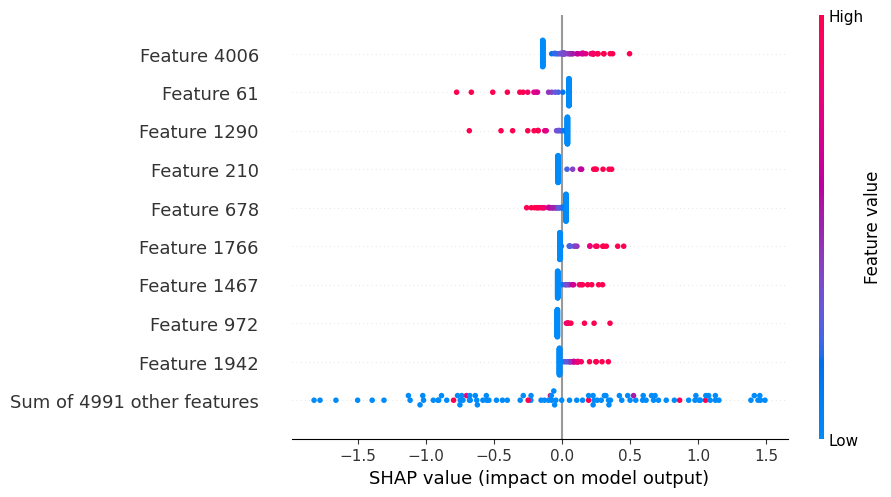

In [ ]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

import shap
explainer = shap.Explainer(model, X_train_dense)
shap_values = explainer(X_test_dense[:100])

# Show SHAP values only for class index 2 (Major)
shap.plots.beeswarm(shap_values[:, :, 0])



In [ ]:
label_encoder.classes_
# ['Blocker', 'Critical', 'Major', 'Minor', 'Trivial']


array(['Blocker', 'Critical', 'Major', 'Minor', 'Trivial'], dtype=object)

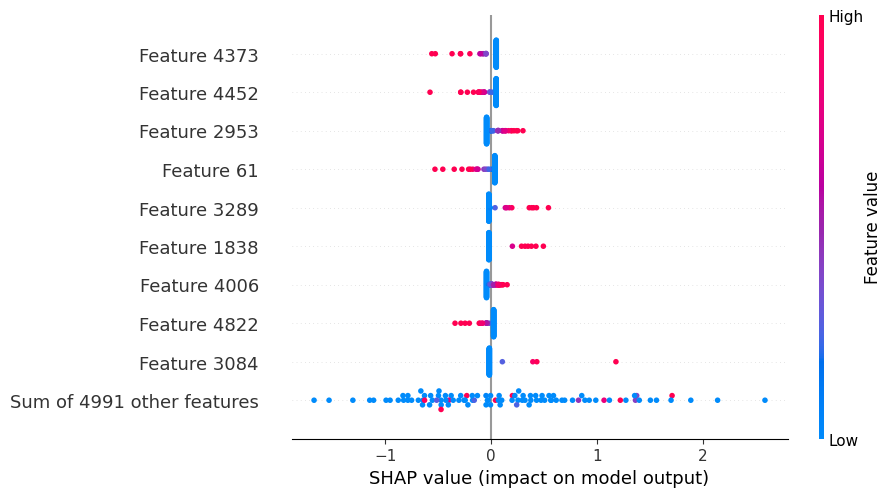

In [ ]:
shap.plots.beeswarm(shap_values[:, :, 1])


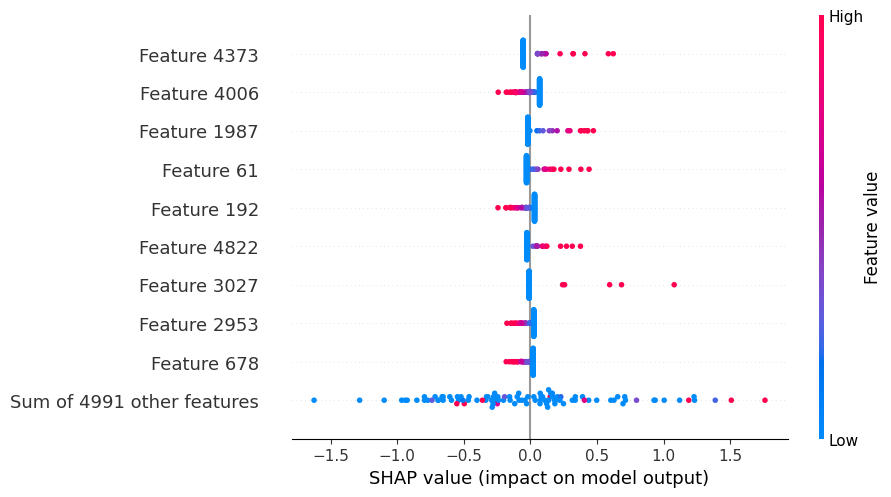

In [ ]:
shap.plots.beeswarm(shap_values[:, :, 2])


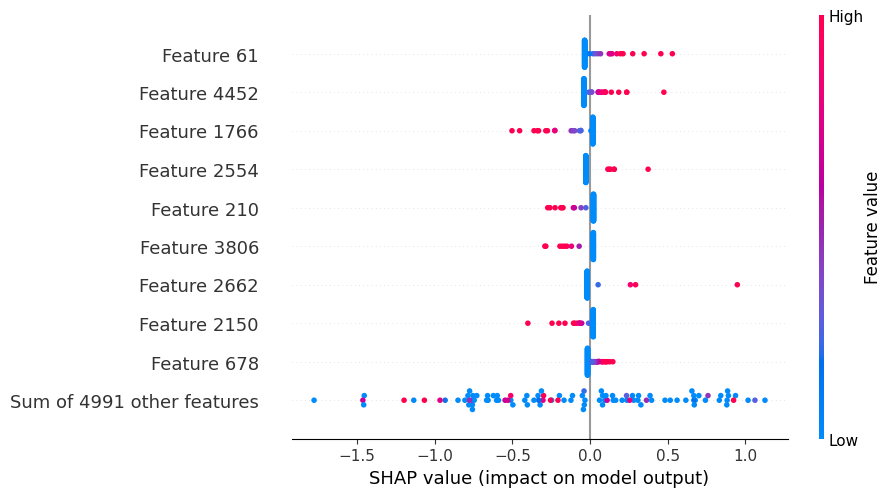

In [ ]:
shap.plots.beeswarm(shap_values[:, :, 3])


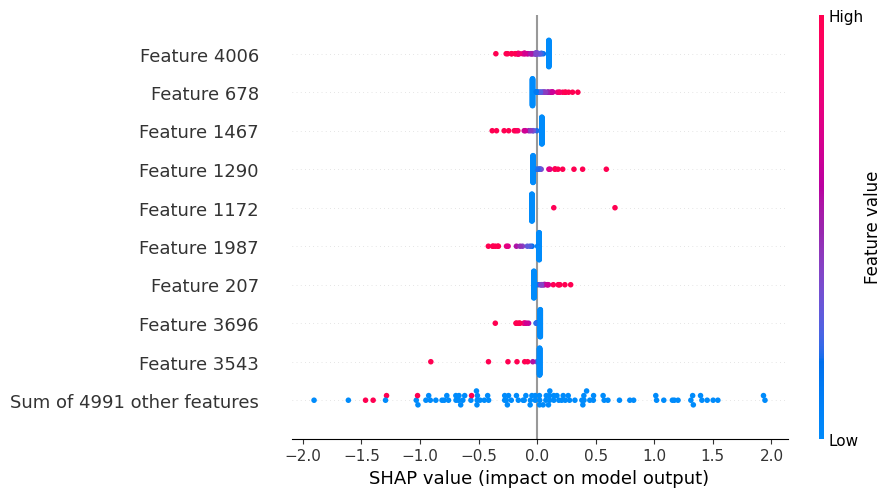

In [ ]:
shap.plots.beeswarm(shap_values[:, :, 4])


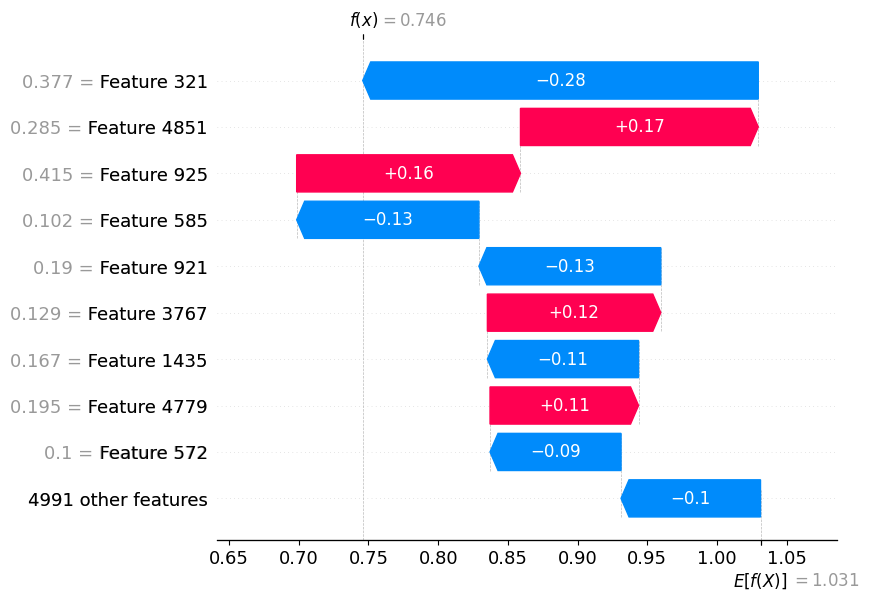

In [ ]:
shap.plots.waterfall(shap_values[0, :, 2])  # First instance, class “Major”


# SMOTE for Balancing

In [ ]:
from imblearn.over_sampling import SMOTE

# Make sure you have dense vectors (SMOTE doesn't work with sparse)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train.toarray(), y_train)

# Check class distribution
from collections import Counter
print("Before:", Counter(y_train))
print("After:", Counter(y_resampled))


Before: Counter({2: 7814, 3: 2213, 4: 302, 0: 222, 1: 188})
After: Counter({2: 7814, 1: 7814, 3: 7814, 4: 7814, 0: 7814})


# Retrain Your Best Model

In [ ]:
model_smote = LogisticRegression(max_iter=1000)
model_smote.fit(X_resampled, y_resampled)

y_pred_smote = model_smote.predict(X_test.toarray())

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_smote, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

     Blocker       0.08      0.21      0.12        56
    Critical       0.07      0.17      0.10        47
       Major       0.82      0.65      0.72      1953
       Minor       0.35      0.46      0.40       553
     Trivial       0.13      0.25      0.17        76

    accuracy                           0.58      2685
   macro avg       0.29      0.35      0.30      2685
weighted avg       0.67      0.58      0.62      2685



# SMOTE + XGBoost ( Trying different model)

In [ ]:
from xgboost import XGBClassifier

xgb_smote = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_smote.fit(X_resampled, y_resampled)

y_pred_xgb = xgb_smote.predict(X_test.toarray())
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:06:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

     Blocker       0.12      0.05      0.07        56
    Critical       0.31      0.11      0.16        47
       Major       0.78      0.82      0.80      1953
       Minor       0.34      0.33      0.33       553
     Trivial       0.12      0.09      0.11        76

    accuracy                           0.67      2685
   macro avg       0.33      0.28      0.29      2685
weighted avg       0.65      0.67      0.66      2685



# Ensemble Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

logreg = LogisticRegression(max_iter=1000)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
rf = RandomForestClassifier()

ensemble = VotingClassifier(
    estimators=[('lr', logreg), ('xgb', xgb), ('rf', rf)],
    voting='soft'  # use predicted probabilities
)

ensemble.fit(X_resampled, y_resampled)
y_pred_ens = ensemble.predict(X_test.toarray())

print(classification_report(y_test, y_pred_ens, target_names=label_encoder.classes_))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:09:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

     Blocker       0.09      0.04      0.05        56
    Critical       0.15      0.06      0.09        47
       Major       0.79      0.85      0.82      1953
       Minor       0.39      0.34      0.36       553
     Trivial       0.26      0.13      0.17        76

    accuracy                           0.69      2685
   macro avg       0.33      0.29      0.30      2685
weighted avg       0.66      0.69      0.68      2685



# Gradio App

In [ ]:
import gradio as gr

# Load model and vectorizer if needed
# (skip if you're using them live in notebook)

def clean_input_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", text)
    tokens = text.lower().split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

def predict_priority(summary, description):
    full_text = summary + " " + description
    cleaned = clean_input_text(full_text)
    vectorized = tfidf.transform([cleaned])
    prediction = ensemble.predict(vectorized.toarray())
    return label_encoder.inverse_transform(prediction)[0]

interface = gr.Interface(
    fn=predict_priority,
    inputs=[
        gr.Textbox(label="Bug Summary"),
        gr.Textbox(label="Bug Description", lines=4)
    ],
    outputs="text",
    title="AI Task Priority Classifier",
    description="Enter the summary and description of a bug or task to predict its priority level."
)

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://341540c9ca823bc281.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
combined_df['PredictedPriority'] = ensemble.predict(X.toarray())
combined_df['PredictedLabel'] = label_encoder.inverse_transform(combined_df['PredictedPriority'])
combined_df.to_csv('ai_task_predictions.csv', index=False)
